In [ ]:
import numpy as np 
import pandas as pd 
import os
import sys
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/STOR565 Project')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("mbtiJorP.csv")

In [ ]:
data.head()

,Unnamed: 0,JorP,posts
0,0,J,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,1,P,'I'm finding the lack of me in these posts ver...
2,2,P,'Good one _____ https://www.youtube.com/wat...
3,3,J,"'Dear INTP, I enjoyed our conversation the o..."
4,4,J,'You're fired.|||That's another silly misconce...


In [ ]:
types = np.unique(data.JorP.values)

In [ ]:
def get_type_index(string):
    return list(types).index(string)

In [ ]:
data['type_index'] = data['JorP'].apply(get_type_index)


In [ ]:
data.posts.values[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [ ]:
import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = [i for i in words if not "http" in i]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words

In [ ]:
data['cleaned_text'] = data['posts'].apply(clean_text)

In [ ]:
data.cleaned_text.values[0]

'enfp  and  intj  moments  sportscenter  not  top  ten  plays  pranks  what  has  been  the  most  lifechanging  experience  in  your  life  on  repeat  for  most  of  today  may  the  perc  experience  immerse  you  the  last  thing  my  infj  friend  posted  on  his  facebook  before  committing  suicide  the  next  day  rest  in  peace  hello  enfj7  sorry  to  hear  of  your  distress  its  only  natural  for  a  relationship  to  not  be  perfection  all  the  time  in  every  moment  of  existence  try  to  figure  the  hard  times  as  times  of  growth  as  84389  84390    welcome  and  stuff  game  set  match  prozac  wellbrutin  at  least  thirty  minutes  of  moving  your  legs  and  i  dont  mean  moving  them  while  sitting  in  your  same  desk  chair  weed  in  moderation  maybe  try  edibles  as  a  healthier  alternative  basically  come  up  with  three  items  youve  determined  that  each  type  or  whichever  types  you  want  to  do  would  more  than  likely  us

In [ ]:
data.head()

,Unnamed: 0,JorP,posts,type_index,cleaned_text
0,0,J,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,enfp and intj moments sportscenter not t...
1,1,P,'I'm finding the lack of me in these posts ver...,1,im finding the lack of me in these pos...
2,2,P,'Good one _____ https://www.youtube.com/wat...,1,good one of course to which i say i ...
3,3,J,"'Dear INTP, I enjoyed our conversation the o...",0,dear intp i enjoyed our conversation the...
4,4,J,'You're fired.|||That's another silly misconce...,0,youre fired thats another silly misconcep...


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data)
train, val = train_test_split(train)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data.cleaned_text.values)

In [ ]:
maxlen = 1500
train_sequences = tokenizer.texts_to_sequences(train.cleaned_text.values)
train_padded = pad_sequences(train_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

val_sequences = tokenizer.texts_to_sequences(val.cleaned_text.values)
val_padded = pad_sequences(val_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

In [ ]:
train_padded

array([[1223,  958, 2487, ...,    0,    0,    0],
       [  17,    8,   25, ...,  103,    2,  845],
       [  81,  233,    2, ...,    0,    0,    0],
       ...,
       [  19,  124,  121, ...,  775,    6,    2],
       [  36,   50,   19, ...,    0,    0,    0],
       [   2,   43, 2118, ...,    0,    0,    0]], dtype=int32)

In [ ]:
one_hot_labels = tf.keras.utils.to_categorical(train.type_index.values, num_classes=2)
val_labels= tf.keras.utils.to_categorical(val.type_index.values, num_classes=2)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout, Conv1D, GlobalMaxPooling1D

def create_model():
    op = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model = Sequential()
    model.add(Embedding(vocab_size, 256, input_length=maxlen))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(200, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(20)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])
    return model

In [ ]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 256)         2560000   
                                                                 
 dropout (Dropout)           (None, 1500, 256)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1500, 400)        731200    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1500, 400)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               67360     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 40)                0

In [ ]:
history = model.fit(train_padded, one_hot_labels, epochs =10, verbose = 1, validation_data = (val_padded, val_labels),  callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)])

Epoch 1/10
153/153 [==============================] - 245s 2s/step - loss: 0.6895 - accuracy: 0.5688 - val_loss: 0.6835 - val_accuracy: 0.6060
Epoch 2/10
153/153 [==============================] - 223s 1s/step - loss: 0.6804 - accuracy: 0.6048 - val_loss: 0.6746 - val_accuracy: 0.6060
Epoch 3/10
153/153 [==============================] - 223s 1s/step - loss: 0.6731 - accuracy: 0.6055 - val_loss: 0.6699 - val_accuracy: 0.6060
Epoch 4/10
153/153 [==============================] - 223s 1s/step - loss: 0.6710 - accuracy: 0.6055 - val_loss: 0.6692 - val_accuracy: 0.6060
Epoch 5/10
153/153 [==============================] - 223s 1s/step - loss: 0.6722 - accuracy: 0.6055 - val_loss: 0.6691 - val_accuracy: 0.6060
Epoch 6/10
153/153 [==============================] - 223s 1s/step - loss: 0.6703 - accuracy: 0.6055 - val_loss: 0.6690 - val_accuracy: 0.6060
Epoch 7/10
153/153 [==============================] - 223s 1s/step - loss: 0.6715 - accuracy: 0.6055 - val_loss: 0.6690 - val_accuracy: 0.6060

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


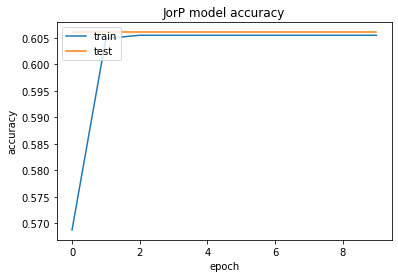

In [ ]:
import keras
from matplotlib import pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('JorP model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('JorP model accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

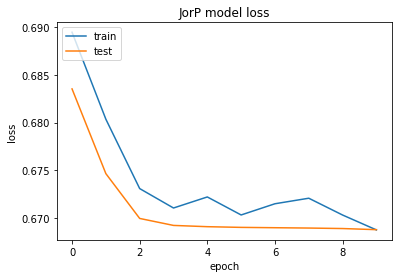

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('JorP model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('JorP model loss.png', dpi=300, bbox_inches='tight')
plt.show()